# Поиск дневных закономерностей в доходностях.

В этом файле мы ищем закономерности для обыкновенных акций и фьючерса *Сбербанка* в зависимости от числа месяца. (Период 01.01.2010-31.12.2019. Загружены с сайта Финама).

Алгоритм следующий:
1. [Импорт данных](#1.-Импорт-данных.);
2. [График цены](#2.-График-цены.);
3. [Процентное изменение цены БА для каждого дня](#3.-Процентное-изменение-цены-БА-для-каждого-дня.);
4. [Медиана доходности за определенный день](#4.-Медиана-доходности-за-определенный-день.);
5. [Доходность за определенный день](#5.-Доходность-за-определенный-день.);
6. [Медиана доходности по дням недели](#6.-Медиана-доходности-по-дням-недели.);
7. [Подготовка данных для опционнойстратегии](#7.-Подготовка-данных-для-опционной-стратегии.).

## 1. Импорт данных.

Импортируем необходимые модули и присваиваем переменным названия файлов, содержащих данные по акции и фьючерсу.  
Также называем столбцы в выходных данных

In [1]:
# Импортируем пакет Pandas
import pandas as pd

# Импорт numpy пакета
import numpy as np

# Импортируем пакет matplotlib для графиков
import matplotlib as mpl
import matplotlib.pyplot as plt
large = 32; med = 24; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': small,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': large,
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')

# Название компании для отображения на графике
title_name = 'Сбербанк'

# Имена файлов.
file_name_ao = 'SBER_100101_191231_day.csv' # Данные скачены с сайта Финама.
file_name_fut = 'SPFB.SBRF_100101_191231_day_gluing.csv'

# Названия столбцов для новой таблицы
columns = ['close_share', 'close_fut']
columns_ao = ['time','open','high','low','close','vol']

Пример данных для загрузки:

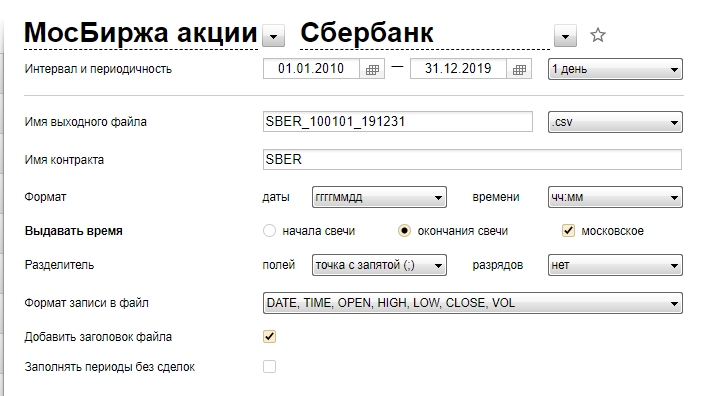

Читаем данные с помощью функции *read_csv*. В качестве аргумента подставляем:  
- имя файла, 
- разделитель - точка с запятой, 
- индекс - первый столбец, 
- дата - столбец 'DATE' (можно было вместо 'DATE' поставить True, т.к. это индекс)

Создаем новый dataframe с ценами закрытия акции и фьючерса, при этом заполняем пустые значения в строке значением предыдущей строчки (метод *ffill*).

Выделяем *день*, *название дня недели*, *месяц* и *номер дня недели* в отдельные столбцы.

In [2]:
# Чтение данных из CSV файла
df_share = pd.read_csv(file_name_ao, sep=";", index_col=0, parse_dates=['<DATE>'])
df_fut = pd.read_csv(file_name_fut, sep=";", index_col=0, parse_dates=['<DATE>'])

# Создание нового dataframe с двумя столбцами: цена акции на закрытие и цена фьючерса на закрытие.
df = pd.DataFrame({'col1':df_share['<CLOSE>'],'col2':df_fut['<CLOSE>'], })
df = df.fillna(method='ffill')
df_share = df_share.fillna(method='ffill')

# Даем имена столбцам.
df.columns = columns
df.index.names = ['Date']

df_share.columns = columns_ao
df_share.index.names = ['Date']
#df_share['day'] = df_share.index.strftime('%d')
#df.index = pd.to_datetime(df.index)

# Сохраняем день, название дня недели и месяц в соответствующие новые столбцы
df['day'] = df.index.strftime('%d')
df['name_day'] = df.index.strftime('%a')
df['month'] = df.index.strftime('%m')
df['day_of_week'] = df.index.strftime('%w')

df.head()

,close_share,close_fut,day,name_day,month,day_of_week
Date,,,,,,
2010-01-11,86.69,8695.0,11,Mon,01,1
2010-01-12,85.00,8474.0,12,Tue,01,2
2010-01-13,86.61,8771.0,13,Wed,01,3
2010-01-14,87.55,8789.0,14,Thu,01,4
2010-01-15,88.15,8820.0,15,Fri,01,5


## 2. График цены.

Рисуем график цены (по закрытию) акции фьючерса для данной компании.

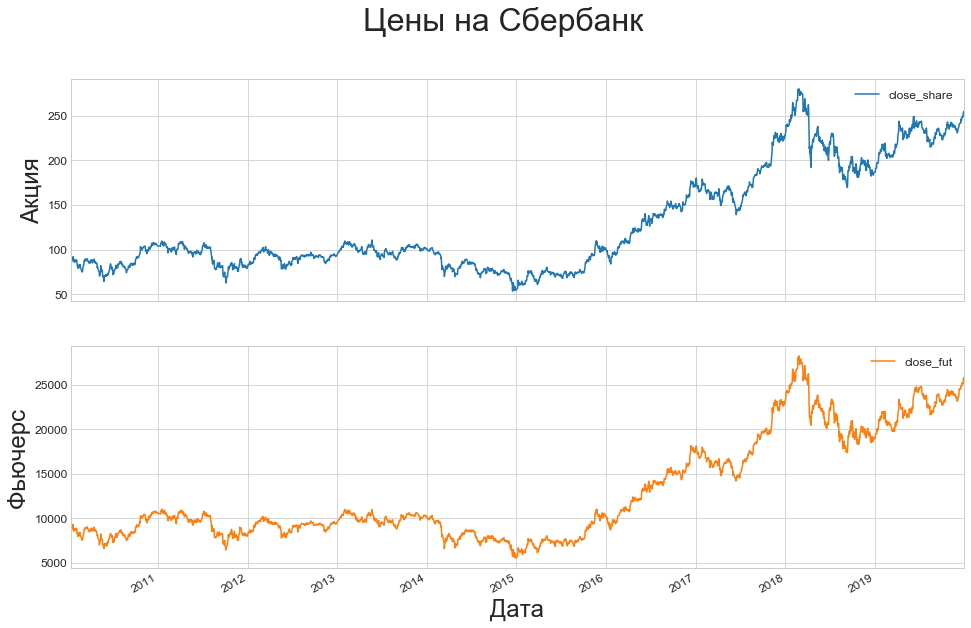

In [3]:
# Устанавливаем стили для графиков.
# plt.style.use('fivethirtyeight')
axes = df.plot(subplots=True, 
               title = f"Цены на {title_name}",
               figsize=(16,10))
axes[1].set_xlabel('Дата')
axes[0].set_ylabel('Акция')
axes[1].set_ylabel('Фьючерс');

## 3. Процентное изменение цены БА для каждого дня.

Для вычисления процентного изменения за день используем встроенную функцию в *pct_change()*.

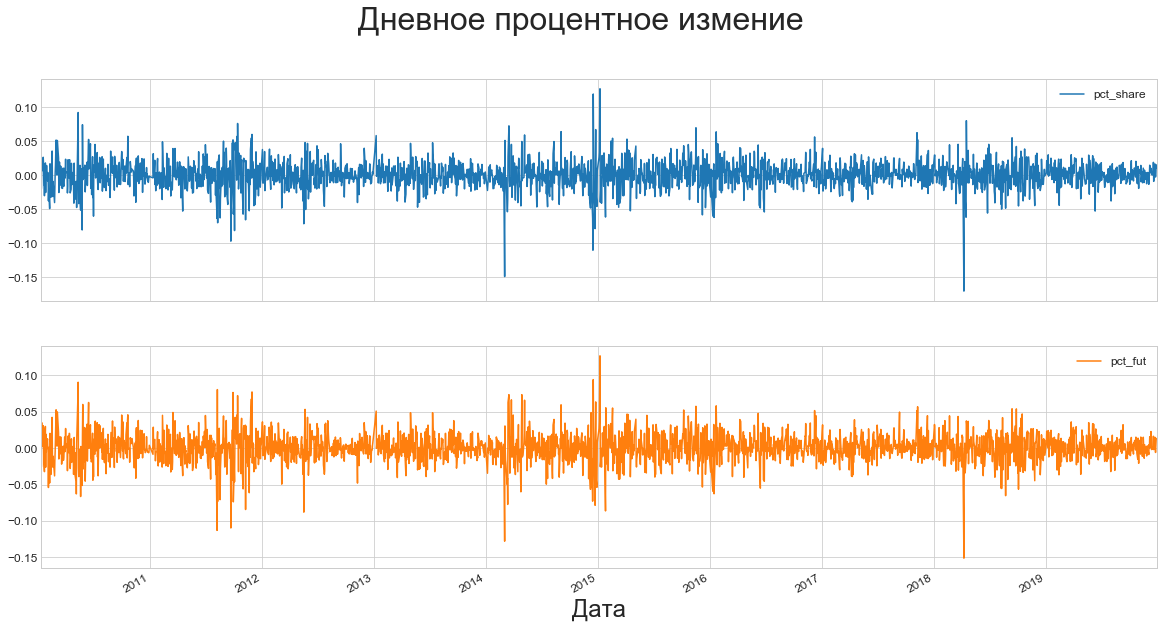

In [4]:
# Вычисляем процентное соотношение
df['pct_share'] = df['close_share'].pct_change()
df['pct_fut'] = df['close_fut'].pct_change()

# Рисуем график
# plt.figure(figsize=(20,10))
df.plot(y=['pct_share', 'pct_fut'], 
        title = 'Дневное процентное измение', 
        subplots=True, 
        figsize=(20, 10))
plt.xlabel('Дата')
plt.show()

**Гистограмма дневной доходности**

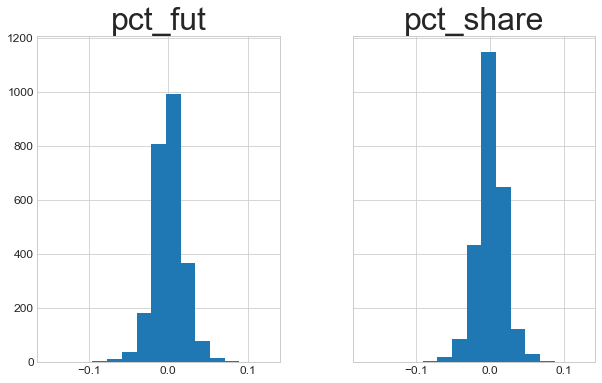

In [5]:
df.hist(column=['pct_share', 'pct_fut'], 
        figsize=(10, 6),
        sharey=True,
        bins=15)
plt.show()

Цена в основном изменяется в пределах от -5% до 5%. Но не редки и более сильные всплески, причем как в плюс, так и в мину.

## 4. Медиана доходности за определенный день.

Ценовые графики часто имеют "выбросы" цены, которые смещают среднее значение. Поэтому вместо среднего вычисляем медиану.<br>
Функция для расчета медианы доходности акции и фьючерса (по-умолчанию, группирует по дням).  

In [6]:
def calc_median_return(df, col, group_name = df.day):
    # Вычисляем изменение цены за день
    day_wise_returns = df.groupby(group_name)[col]
    
    # Возвращает среднее изменение цены за день (%)
    return (day_wise_returns.median()*100)

# Выводим отсортированные данные по дням
print(calc_median_return(df, 'pct_share').sort_values(ascending=False))
print(calc_median_return(df, 'pct_fut').sort_values(ascending=False))

day
07    0.347082
03    0.343019
21    0.275823
17    0.272205
30    0.264927
02    0.214770
29    0.192748
18    0.190763
09    0.157831
14    0.142741
20    0.123854
13    0.066498
01    0.057179
06    0.024474
05    0.008461
31    0.005450
15    0.000000
24   -0.046956
25   -0.062991
28   -0.070208
12   -0.073082
11   -0.074794
16   -0.081641
27   -0.107631
26   -0.123166
10   -0.126904
04   -0.250197
23   -0.252278
22   -0.269661
08   -0.281112
19   -0.328736
Name: pct_share, dtype: float64
day
10    0.464473
03    0.422035
18    0.394330
17    0.287875
21    0.232043
16    0.202494
25    0.134875
02    0.117304
29    0.107630
14    0.101348
13    0.092994
05    0.089414
30    0.084104
08    0.059268
11    0.058382
09    0.054996
07    0.036490
20    0.000000
24   -0.010687
28   -0.027045
31   -0.044262
12   -0.062890
27   -0.063857
26   -0.084746
06   -0.097525
22   -0.133967
23   -0.148205
04   -0.191021
15   -0.204057
01   -0.232515
19   -0.499409
Name: pct_fut, dtype: float64


**Вывод:**  
Ожидал увидеть значительные изменения цены в конце месяца для акций и/или в моменты экспирации фьючерсов.  
Однозначных проявлений не замечено. Можно только выделить 7-е число для акций.

## 5. Доходность за определенный день.

Выберем лучший день в месяце и посмотрим на доходность графика, если торговать один раз в месяц.

In [7]:
day = '07' # формат чч, т.е. 7 число нужно записывать через 07
df[df['day'] == day].tail()

,close_share,close_fut,day,name_day,month,day_of_week,pct_share,pct_fut
Date,,,,,,,,
2019-05-07,231.49,21885.0,07,Tue,05,2,-0.005627,-0.011964
2019-06-07,248.28,23567.0,07,Fri,06,5,0.013843,0.013199
2019-08-07,222.25,22596.0,07,Wed,08,3,-0.016636,-0.010423
2019-10-07,227.55,23032.0,07,Mon,10,1,0.021503,0.014670
2019-11-07,242.50,24276.0,07,Thu,11,4,0.014559,0.015222


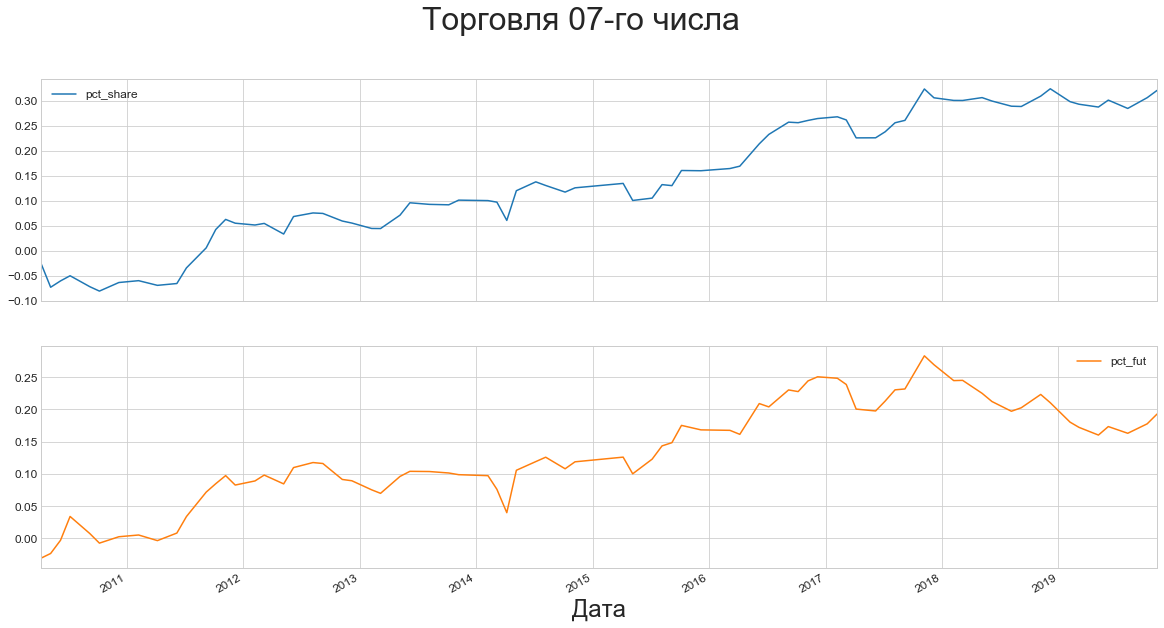

In [8]:
# Рисуем график для определенного дня месяца
df[df['day'] == day].cumsum().plot(y=['pct_share', 'pct_fut'], 
        title = f'Торговля {day}-го числа', 
        subplots=True, 
        figsize=(20, 10))
plt.xlabel('Дата')
plt.show()

In [9]:
# Медиана за определенный день.
median_day = df[df['day'] == str(day)]['pct_share'].median()

# Медиана за весь период.
median_day_share = df['pct_share'].median()

print('Медиана за {}-е число равна: {:.4%}, а за весь период: {:.4%}'.format(day, median_day, median_day_share))

Медиана за 07-е число равна: 0.3471%, а за весь период: 0.0128%


Если покупать акции Сбербанка исключительно 7 числа, то будет накапливаться прибыль! Причем фьючерс выглядит хуже. Видимо торговля в вечернюю сессию в этот день излишня.

Если смотреть другие дни, то графики получаются рваными и такой четкой тенденции как для 7-го числа не прослеживается.

**Фундаментальной причины для покупки 7-го числа нет, но вот продаж в этот день лучше избежать.**

Можно также исследовать день недели в связке с месяцев или днем недели (раскомментировав/закомментировав строки 6 и 7 ячейки ниже):

In [10]:
# Номер дня месяца и день недели для исследования
month_research = '07'
name_day_research = "Wed" # Mon, Tue, Wed, Thu, Fri

df[(df['day'] == str(day)) & 
#    (df['name_day'] == name_day_research) ]
     (df['month'] == month_research) ]

,close_share,close_fut,day,name_day,month,day_of_week,pct_share,pct_fut
Date,,,,,,,,
2010-07-07,77.49,7876.0,07,Wed,07,3,0.010300,0.036998
2011-07-07,107.62,10809.0,07,Thu,07,4,0.031238,0.025619
2014-07-07,85.49,8634.0,07,Mon,07,1,0.017738,0.013499
2015-07-07,68.77,7140.0,07,Tue,07,2,0.004675,0.022776
2016-07-07,131.80,13310.0,07,Thu,07,4,0.018862,-0.005157
2017-07-07,152.16,15533.0,07,Fri,07,5,0.012039,0.015361


**Хорошая для торговли, получается, дата 07.07.**

## 6. Медиана доходности по дням недели.

In [11]:
df_name_day = calc_median_return(df, 'pct_share', df['name_day']).sort_values(ascending=False)
df_name_day

name_day
Sun    1.934889
Sat    0.245761
Mon    0.120420
Tue    0.032397
Wed    0.021763
Thu    0.012042
Fri   -0.079286
Name: pct_share, dtype: float64

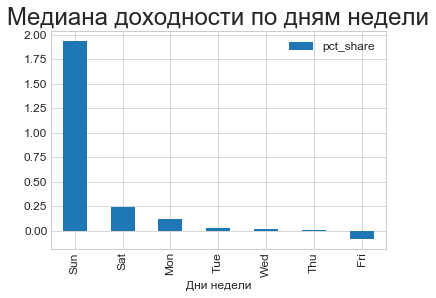

In [12]:
plot_med = df_name_day.plot(kind='bar', legend=True)
# plot_med.set_xlabel('Дни недели', fontsize = small)
plt.xlabel('Дни недели', fontsize = small)
plt.title("Медиана доходности по дням недели", fontsize = med);

**Если торговый день приходится на выходные дни, то покупка акций Сбербанка может быть привлекательной, особенно в воскресенье.**

## 7. Подготовка данных для опционной стратегии.

Опционы на фьючерсы с БА на акции последние годы экспирируются в третью среду каждого месяца. Поэтому покупка/продажа опционов производится в середине месяца и имеют ограниченный срок "жизни". Поэтому для анализа опционов в каждый месяц, нужно делать это не с первого числа, а со смещением.

Для идентичных расчетов сделано допущение, что опционы с 2010 года всегда экспирировались в третью среду месяца.

Создаем дополнительный столбец *expiration*, в который записываем '1', если в этот день была экспирация, т.е. ищем 3-ю среду каждого месяца.

In [13]:
# День экспирации опционов. Для акций - каждая третья среда
day_of_week = 3 # 0-Вс, 1 - Пн и т.д.

# Каждый день на 3-ей неделе лежит между 15-м и 21 числом
day_start = 15
day_finish = 21

# Ищем день на 3-й неделе и присваиваем единицу в столбец expiration
df['expiration'] = np.where(((df.day.astype(int) >= day_start) & 
                                 (df.day.astype(int) <= day_finish) & 
                                 (df.day_of_week.astype(int) == 3)), 1, 0)

df.tail(10)

,close_share,close_fut,day,name_day,month,day_of_week,pct_share,pct_fut,expiration
Date,,,,,,,,,
2019-12-17,241.60,24500.0,17,Tue,12,2,0.000621,-0.001467,0
2019-12-18,246.20,24900.0,18,Wed,12,3,0.019040,0.016327,1
2019-12-19,244.00,24850.0,19,Thu,12,4,-0.008936,-0.002008,0
2019-12-20,244.71,24850.0,20,Fri,12,5,0.002910,0.000000,0
2019-12-23,248.80,25220.0,23,Mon,12,1,0.016714,0.014889,0
2019-12-24,248.67,25231.0,24,Tue,12,2,-0.000523,0.000436,0
2019-12-25,248.04,25081.0,25,Wed,12,3,-0.002533,-0.005945,0
2019-12-26,248.24,25173.0,26,Thu,12,4,0.000806,0.003668,0
2019-12-27,252.06,25485.0,27,Fri,12,5,0.015388,0.012394,0


В csv-файл записываем данные только тех дней, когда была экспирация. Т.е. как будто это окончание "месяца".

In [14]:
#Записисываем данные в csv-файл
df_new = df[df['expiration']==1]
df_new.drop(['close_share', 'day_of_week', 'pct_share', 'pct_fut', 'expiration'], axis='columns', inplace=True)
export_csv = df_new.to_csv(r'df_futures.csv', index = 'Date', header=True)

df_new.tail(12)

C:\tools\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,close_fut,day,name_day,month
Date,,,,
2019-01-16,20558.0,16,Wed,01
2019-02-20,20878.0,20,Wed,02
2019-03-20,20161.0,20,Wed,03
2019-04-17,22356.0,17,Wed,04
2019-05-15,21702.0,15,Wed,05
2019-06-19,24525.0,19,Wed,06
2019-07-17,23866.0,17,Wed,07
2019-08-21,22020.0,21,Wed,08
2019-09-18,23949.0,18,Wed,09


Эти данные необходимы для исследований в опционах и используются в других notebook'ах.

**Вывод:**  
Некоторые авторы книг/статей говорят о закономерностях в конце месяца (чаще растем). Если это так, то последние числа месяца должны были как-то выделяться. Подобного не замечено.  
Однако, обнаружена дата с "магическим" числом 7. 